In [3]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from classificatiom_model import EarlyStopping, ModelSaver,train_classification_model,plot_learning_curves
from classificatiom_model import evaluate_classification_model as evaluate_model

In [4]:
import json
token = {"username":"eviltrashcan","key":"5a0836e4ef86086fdadf624206bd1421"}
with open('/content/kaggle.json', 'w') as file:
  json.dump(token, file)

In [5]:
!cat /content/kaggle.json

{"username": "eviltrashcan", "key": "5a0836e4ef86086fdadf624206bd1421"}

In [6]:
!mkdir -p ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle config set -n path -v /content

- path is now set to: /content


In [7]:
!kaggle competitions download -c cifar-10

 97% 691M/715M [00:03<00:00, 128MB/s] 
100% 715M/715M [00:03<00:00, 210MB/s]


In [8]:
!unzip /content/competitions/cifar-10/cifar-10.zip

Archive:  /content/competitions/cifar-10/cifar-10.zip
  inflating: sampleSubmission.csv    
  inflating: test.7z                 
  inflating: train.7z                
  inflating: trainLabels.csv         


In [9]:
%pip install py7zr
import py7zr
a =py7zr.SevenZipFile(r'./train.7z','r')
a.extractall(path=r'./competitions/cifar-10/')
a.close()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 67.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.4/96.4 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.3/141.3 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 412.9/412.9 kB 39.1 MB/s eta 0:00:00


In [10]:
!ls competitions/cifar-10/train|wc -l

50000


In [11]:
# 加载CIFAR-10数据集
import os
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset

# 定义CIFAR-10数据集类
class CIFAR10Dataset(Dataset):
    def __init__(self, img_dir, labels_file, transform=None):
        self.img_dir = img_dir
        self.transform = transform

        # 读取标签文件，read_csv默认读取第一行作为列名
        self.labels_df = pd.read_csv(labels_file)
        self.img_names = self.labels_df.iloc[:, 0].values.astype(str)  # 第一列是图片名称，确保为字符串类型

        # 类别名称字典，使用字典可以提高查找速度
        self.class_names_dict = {'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3,
                                 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}
        # 将文本标签转换为数字ID
        self.labels = [self.class_names_dict[label] for label in self.labels_df.iloc[:, 1].values]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_names[idx] + '.png') #图片路径
        image = Image.open(img_path) #打开图片
        label = self.labels[idx]

        if self.transform:
            image_tensor = self.transform(image)

        return image_tensor, label

# 定义数据预处理
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4917, 0.4823, 0.4467), (0.2024, 0.1995, 0.2010))
])

# colab加载CIFAR-10数据集
img_dir = r"competitions/cifar-10/train"
labels_file = r"./trainLabels.csv"

# img_dir = r"D:\BaiduNetdiskDownload\1.Python11期\深度学习代码\cifar-10\train"
# labels_file = r"D:\BaiduNetdiskDownload\1.Python11期\深度学习代码\cifar-10\trainLabels.csv"
full_dataset = CIFAR10Dataset(img_dir=img_dir, labels_file=labels_file, transform=transform)

# 定义类别名称
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# 划分训练集和验证集
train_size = 45000
val_size = 5000
generator = torch.Generator().manual_seed(42)
train_dataset, val_dataset = torch.utils.data.random_split(
    full_dataset,
    [train_size, val_size],
    generator=generator
)

# 查看数据集基本信息
print(f"完整数据集大小: {len(full_dataset)}")
print(f"训练集大小: {len(train_dataset)}")
print(f"验证集大小: {len(val_dataset)}")


完整数据集大小: 50000
训练集大小: 45000
验证集大小: 5000


In [12]:

# 创建数据加载器
batch_size = 64
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True #打乱数据集，每次迭代时，数据集的顺序都会被打乱
)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False
)




In [13]:
# 自定义InceptionNet模型
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# 定义Inception模块
class InceptionModule(nn.Module):
    def __init__(self, in_channels, ch1x1, ch3x3red, ch3x3, ch5x5red, ch5x5, pool_proj):
        """
        Inception模块初始化

        参数:
            in_channels: 输入通道数
            ch1x1: 1x1卷积分支的输出通道数
            ch3x3red: 3x3卷积分支中1x1卷积的输出通道数(降维)
            ch3x3: 3x3卷积分支中3x3卷积的输出通道数
            ch5x5red: 5x5卷积分支中1x1卷积的输出通道数(降维)
            ch5x5: 5x5卷积分支中5x5卷积的输出通道数
            pool_proj: 池化分支中1x1卷积的输出通道数
        """
        super(InceptionModule, self).__init__()

        # 1x1卷积分支 - 直接进行特征提取和降维
        self.branch1 = nn.Conv2d(in_channels, ch1x1, kernel_size=1)

        # 1x1卷积 -> 3x3卷积分支 - 先降维再提取特征
        self.branch2 = nn.Sequential(
            nn.Conv2d(in_channels, ch3x3red, kernel_size=1),  # 降维
            nn.ReLU(inplace=True),  # 激活函数
            nn.Conv2d(ch3x3red, ch3x3, kernel_size=3, padding=1)  # 特征提取
        )

        # 1x1卷积 -> 5x5卷积分支 - 先降维再提取更大感受野的特征
        self.branch3 = nn.Sequential(
            nn.Conv2d(in_channels, ch5x5red, kernel_size=1),  # 降维
            nn.ReLU(inplace=True),  # 激活函数
            nn.Conv2d(ch5x5red, ch5x5, kernel_size=5, padding=2)  # 大感受野特征提取
        )

        # 3x3池化 -> 1x1卷积分支 - 先池化再降维
        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),  # 池化提取主要特征
            nn.Conv2d(in_channels, pool_proj, kernel_size=1)  # 降维
        )

    def forward(self, x):
        """前向传播函数"""
        # 对每个分支进行计算并应用ReLU激活函数
        branch1 = F.relu(self.branch1(x))
        branch2 = F.relu(self.branch2(x))
        branch3 = F.relu(self.branch3(x))
        branch4 = F.relu(self.branch4(x))

        # 在通道维度上拼接所有分支的输出，形成多尺度特征表示
        return torch.cat([branch1, branch2, branch3, branch4], 1)

# 定义自定义的InceptionNet模型
class CustomInceptionNet(nn.Module):
    def __init__(self, num_classes=10):
        """
        自定义InceptionNet模型初始化

        参数:
            num_classes: 分类类别数，默认为10
        """
        super(CustomInceptionNet, self).__init__()

        # 初始卷积层 - 提取基础特征
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)  # 输入图像为3通道
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)  # 降低分辨率

        # 卷积层 - 进一步提取特征
        self.conv2 = nn.Conv2d(64, 64, kernel_size=1)  # 1x1卷积进行通道整合
        self.conv3 = nn.Conv2d(64, 192, kernel_size=3, padding=1)  # 3x3卷积提取特征
        self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)  # 再次降低分辨率

        # Inception模块 - 多尺度特征提取
        # 第一组Inception模块
        self.inception3a = InceptionModule(192, 64, 96, 128, 16, 32, 32)  # 输入192通道，输出256通道
        self.inception3b = InceptionModule(256, 128, 128, 192, 32, 96, 64)  # 输入256通道，输出480通道
        self.maxpool3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)  # 降低分辨率

        # 第二组Inception模块
        self.inception4a = InceptionModule(480, 192, 96, 208, 16, 48, 64)  # 输入480通道，输出512通道
        self.inception4b = InceptionModule(512, 160, 112, 224, 24, 64, 64)  # 输入512通道，输出512通道

        # 全局平均池化 - 将特征图转换为特征向量
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))  # 自适应平均池化到1x1

        # 分类器
        self.dropout = nn.Dropout(0.4)  # 防止过拟合
        self.fc = nn.Linear(512, num_classes)  # 全连接层进行分类

    def forward(self, x):
        """前向传播函数"""
        # 初始层处理
        x = F.relu(self.conv1(x))  # 应用激活函数
        x = self.maxpool1(x)  # 池化

        # 卷积层处理
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.maxpool2(x)

        # Inception模块处理
        x = self.inception3a(x)
        x = self.inception3b(x)
        x = self.maxpool3(x)

        x = self.inception4a(x)
        x = self.inception4b(x)

        # 全局平均池化
        x = self.avgpool(x)
        x = torch.flatten(x, 1)  # 展平特征图为一维向量

        # 分类器
        x = self.dropout(x)  # 应用dropout
        x = self.fc(x)  # 全连接层分类

        return x

# 创建自定义InceptionNet模型实例
model = CustomInceptionNet(num_classes=10)  # 创建10分类的模型实例

print(model)  # 打印模型结构


CustomInceptionNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
  (conv3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (inception3a): InceptionModule(
    (branch1): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1))
    (branch2): Sequential(
      (0): Conv2d(192, 96, kernel_size=(1, 1), stride=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(96, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (branch3): Sequential(
      (0): Conv2d(192, 16, kernel_size=(1, 1), stride=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    )
    (branch4): Sequential(
      (0): MaxPool2d(kernel_size=3, stride=1, padding=1

In [14]:
# 从train_loader获取第一个批次的数据
dataiter = iter(train_loader)
images, labels = next(dataiter)

# 查看批次数据的形状
print("批次图像形状:", images.shape)
print("批次标签形状:", labels.shape)


print('-'*100)
# 进行前向传播
with torch.no_grad():  # 不需要计算梯度
    outputs = model(images)


print(outputs.shape)

批次图像形状: torch.Size([64, 3, 32, 32])
批次标签形状: torch.Size([64])
----------------------------------------------------------------------------------------------------
torch.Size([64, 10])


In [15]:
# 计算模型的总参数量
# 统计需要求梯度的参数总量
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"需要求梯度的参数总量: {total_params}")

# 统计所有参数总量
all_params = sum(p.numel() for p in model.parameters())
print(f"模型总参数量: {all_params}")

# 查看每层参数量明细
print("\n各层参数量明细:")
for name, param in model.named_parameters():
    print(f"{name}: {param.numel()} 参数")

需要求梯度的参数总量: 1507314
模型总参数量: 1507314

各层参数量明细:
conv1.weight: 9408 参数
conv1.bias: 64 参数
conv2.weight: 4096 参数
conv2.bias: 64 参数
conv3.weight: 110592 参数
conv3.bias: 192 参数
inception3a.branch1.weight: 12288 参数
inception3a.branch1.bias: 64 参数
inception3a.branch2.0.weight: 18432 参数
inception3a.branch2.0.bias: 96 参数
inception3a.branch2.2.weight: 110592 参数
inception3a.branch2.2.bias: 128 参数
inception3a.branch3.0.weight: 3072 参数
inception3a.branch3.0.bias: 16 参数
inception3a.branch3.2.weight: 12800 参数
inception3a.branch3.2.bias: 32 参数
inception3a.branch4.1.weight: 6144 参数
inception3a.branch4.1.bias: 32 参数
inception3b.branch1.weight: 32768 参数
inception3b.branch1.bias: 128 参数
inception3b.branch2.0.weight: 32768 参数
inception3b.branch2.0.bias: 128 参数
inception3b.branch2.2.weight: 221184 参数
inception3b.branch2.2.bias: 192 参数
inception3b.branch3.0.weight: 8192 参数
inception3b.branch3.0.bias: 32 参数
inception3b.branch3.2.weight: 76800 参数
inception3b.branch3.2.bias: 96 参数
inception3b.branch4.1.weight: 163

In [16]:
# 定义损失函数和优化器
loss_fn = nn.CrossEntropyLoss()  # 交叉熵损失函数，适用于多分类问题，里边会做softmax，还有会把0-9标签转换成one-hot编码
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)  # SGD优化器，学习率为0.01，动量为0.9
print("损失函数:", loss_fn)

损失函数: CrossEntropyLoss()


In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {device}")
model = model.to(device) #将模型移动到GPU
early_stopping=EarlyStopping(patience=5, delta=0.001)
model_saver=ModelSaver(save_dir='model_weights', save_best_only=True)


model, history = train_classification_model(model, train_loader, val_loader, loss_fn, optimizer, device, num_epochs=50, early_stopping=early_stopping, model_saver=model_saver, tensorboard_logger=None)



使用设备: cuda:0


Training Progress:   0%|          | 0/35200 [00:00<?, ?it/s]

早停触发! 最佳验证准确率: 19.2800
早停: 已有5轮验证损失没有改善！


In [18]:
history['train'][-100:-1]

[{'loss': 2.236733913421631, 'acc': 18.75, 'step': 8401},
 {'loss': 2.243687391281128, 'acc': 6.25, 'step': 8402},
 {'loss': 2.254542350769043, 'acc': 14.0625, 'step': 8403},
 {'loss': 2.2385611534118652, 'acc': 21.875, 'step': 8404},
 {'loss': 2.221869707107544, 'acc': 23.4375, 'step': 8405},
 {'loss': 2.255464792251587, 'acc': 15.625, 'step': 8406},
 {'loss': 2.2398276329040527, 'acc': 18.75, 'step': 8407},
 {'loss': 2.2544105052948, 'acc': 10.9375, 'step': 8408},
 {'loss': 2.263796091079712, 'acc': 12.5, 'step': 8409},
 {'loss': 2.224266767501831, 'acc': 18.75, 'step': 8410},
 {'loss': 2.278782367706299, 'acc': 10.9375, 'step': 8411},
 {'loss': 2.303417205810547, 'acc': 17.1875, 'step': 8412},
 {'loss': 2.2406063079833984, 'acc': 23.4375, 'step': 8413},
 {'loss': 2.2674951553344727, 'acc': 14.0625, 'step': 8414},
 {'loss': 2.2695465087890625, 'acc': 10.9375, 'step': 8415},
 {'loss': 2.224907159805298, 'acc': 29.6875, 'step': 8416},
 {'loss': 2.2447171211242676, 'acc': 12.5, 'step': 

In [19]:
history['val'][-1000:-1]

[{'loss': 2.3027733852386474, 'acc': 9.42, 'step': 0},
 {'loss': 2.30264232711792, 'acc': 9.42, 'step': 500},
 {'loss': 2.302589883041382, 'acc': 9.76, 'step': 1000},
 {'loss': 2.302431523513794, 'acc': 9.42, 'step': 1500},
 {'loss': 2.3025047050476073, 'acc': 9.42, 'step': 2000},
 {'loss': 2.302273889541626, 'acc': 11.24, 'step': 2500},
 {'loss': 2.3023715118408203, 'acc': 12.14, 'step': 3000},
 {'loss': 2.3022750694274903, 'acc': 11.9, 'step': 3500},
 {'loss': 2.3021425792694092, 'acc': 9.42, 'step': 4000},
 {'loss': 2.301901082229614, 'acc': 15.36, 'step': 4500},
 {'loss': 2.3018454319000243, 'acc': 9.42, 'step': 5000},
 {'loss': 2.3014462799072266, 'acc': 13.02, 'step': 5500},
 {'loss': 2.3009159950256346, 'acc': 19.28, 'step': 6000},
 {'loss': 2.3001779487609864, 'acc': 10.36, 'step': 6500},
 {'loss': 2.298694549560547, 'acc': 17.36, 'step': 7000},
 {'loss': 2.2953434459686277, 'acc': 17.4, 'step': 7500},
 {'loss': 2.284854742050171, 'acc': 17.4, 'step': 8000}]

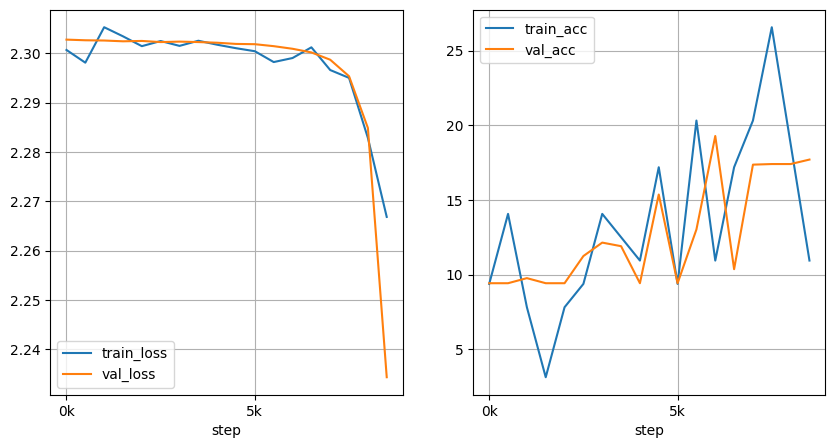

In [20]:
plot_learning_curves(history, sample_step=500)  #横坐标是 steps